In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

### 1. Carga de datos

In [ ]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

### 2. Division y tratamiento de datos

In [ ]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [ ]:
def prepare_data(df, target_column, n_steps):
    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])

    # agregar dia mes y dia de la semana
    features['Month'] = df['Date'].dt.month
    features['Day'] = df['Date'].dt.day
    features['Weekday'] = df['Date'].dt.weekday

    features = features.drop(columns = ['Date'])

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = create_sequences(features_scaled, target, n_steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = False)

    return X_train, X_test, y_train, y_test

### 3. Arquitectura y compilacion

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
def build_model(input_shape, md_prm: dict):
    model = Sequential([
        Conv1D(filters=md_prm['filters'], kernel_size=md_prm['kernel_size'], activation=md_prm['activation'], input_shape=input_shape),
        MaxPooling1D(pool_size=md_prm['pool_size']),
        Dropout(md_prm['dropout']),
        Flatten(),
        Dense(md_prm['dense_units'], activation=md_prm['dense_activation']),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=[rmse])

    return model

### 4. Entrenamiento del modelo

In [ ]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    # Configuración de EarlyStopping
    early_stopping = EarlyStopping(
        monitor             ='val_rmse',
        patience            =20,
        verbose             =1,
        restore_best_weights=True
    )

    # Entrenamiento del modelo con el callback de EarlyStopping
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )

    return history

In [ ]:
# y_train.std()

In [ ]:
# history = train_model(model, X_train, y_train, epochs=100, batch_size=32,)

### 5. Evaluacion de resultado

In [ ]:
def evaluate_model(model, X_test, y_test):
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')

In [ ]:
# evaluate_model(model, X_test, y_test)

In [ ]:
def plot_history(history):
    # plotear loss de entrenamiento y validación
    figsize = (8,3)

    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # otras metricas
    for key in history.history.keys():
        if key not in ['loss', 'val_loss', 'val_rmse']:
            plt.figure(figsize=figsize)
            plt.plot(history.history[key], label=f'Training {key}')
            plt.plot(history.history[f'val_{key}'], label=f'Validation {key}')
            plt.title(f'Model {key.capitalize()}')
            plt.ylabel(key.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            plt.show()

In [ ]:
# plot_history(history)

In [ ]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# n_steps = 25
# target_column = 'LMCADY_acu_5d_log'
# X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)
# y_test.std()
# model = build_model(X_train.shape[1:])
# history = train_model(model, X_train, y_train, epochs=100, batch_size=16)
# evaluate_model(model, X_test, y_test)

In [ ]:
# n_steps_options     = [25, 50, 100, 150, 200]
# batch_size_options  = [32, 64, 128, 256]
n_steps_options     = [27,30,31,21]
batch_size_options  = [16,32]
epochs_options      = [100]

filters_options     = [128]
kernel_size_options = [2, 3, 4]
pool_size_options   = [1]
dense_units_options = [50,100]
dense_activation_options = ['relu']
activation_options  = ['relu']
dropout_options     = [0.1]


model_params_combinations = list(itertools.product(
    filters_options, kernel_size_options, pool_size_options, dense_units_options,
    dense_activation_options, activation_options, dropout_options
))
target_column = 'LMCADY_acu_5d_log'

In [ ]:
def run_model_iterations():
    top_results = []

    i = 1
    for n_steps, batch_size, epochs, (filters, kernel_size, pool_size, dense_units, dense_activation, activation, dropout) in itertools.product(n_steps_options, batch_size_options, epochs_options, model_params_combinations):
        try:
            # Carga de datos
            df = load_data("./input/copper_log_returns_5d_final.csv")

            print(f"\n{i}) Testing with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")

            # Preparación de los datos
            X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps)

            # Configuración de parámetros del modelo
            model_params = {
                'filters'           : filters,
                'kernel_size'       : kernel_size,
                'pool_size'         : pool_size,
                'dense_units'       : dense_units,
                'dense_activation'  : dense_activation,
                'activation'        : activation,
                'dropout'           : dropout
            }

            # Construcción y entrenamiento del modelo
            model   = build_model(X_train.shape[1:], model_params)
            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluación del modelo
            y_pred  = model.predict(X_test)
            rmse_ob = sqrt(mean_squared_error(y_test, y_pred))
            std_dev = y_test.std()

            # Calcular la diferencia absoluta
            difference = rmse_ob - std_dev

            # Guardar y ordenar resultados basados en la diferencia absoluta
            result      = {'difference': difference, 'rmse': rmse_ob, 'std_dev': std_dev, 'params': model_params, 'history': history, 'batch_size': batch_size, 'n_steps': n_steps, 'y_test': y_test}
            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['difference'])[:3]

            print(f"\n{i}) RMSE: {rmse_ob:.6f}, Std Dev: {std_dev:.6f}, Difference: {difference:.6f}")
            print(f"Tested with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")
            print(f"Model params: {model_params}")


        except Exception as e:
            print(f"An error occurred: {e}. Skipping this combination.")
        i += 1

    return top_results

In [ ]:
top_3_results = run_model_iterations()


1) Testing with n_steps=27, batch_size=16, epochs=100, filters=128
Restoring model weights from the end of the best epoch: 6.
Epoch 26: early stopping
26/26 [==============================] - 0s 3ms/step

1) RMSE: 0.030669, Std Dev: 0.030614, Difference: 0.000055
Tested with n_steps=27, batch_size=16, epochs=100, filters=128
Model params: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}

2) Testing with n_steps=27, batch_size=16, epochs=100, filters=128
Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping
26/26 [==============================] - 0s 3ms/step

2) RMSE: 0.030724, Std Dev: 0.030614, Difference: 0.000110
Tested with n_steps=27, batch_size=16, epochs=100, filters=128
Model params: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}

3) Testing with n_steps=27, batch_size=16,


Top 1 Model
Best RMSE: 0.030560 vs. a std of 0.030613
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}
n_steps: 31, batch_size: 32


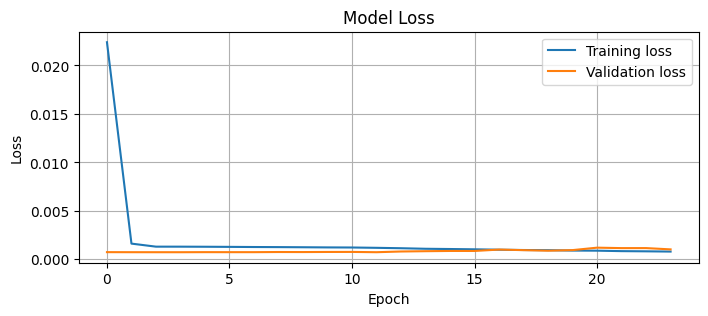

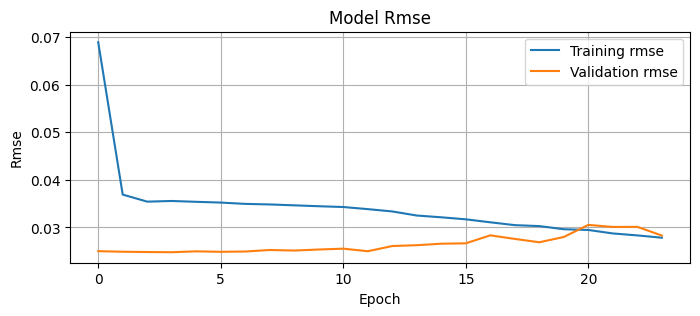


Top 2 Model
Best RMSE: 0.030571 vs. a std of 0.030614
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}
n_steps: 27, batch_size: 32


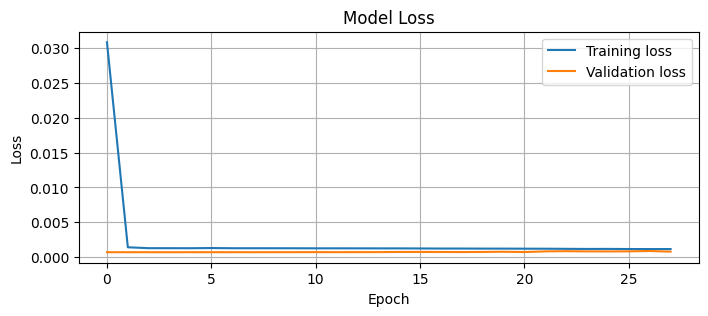

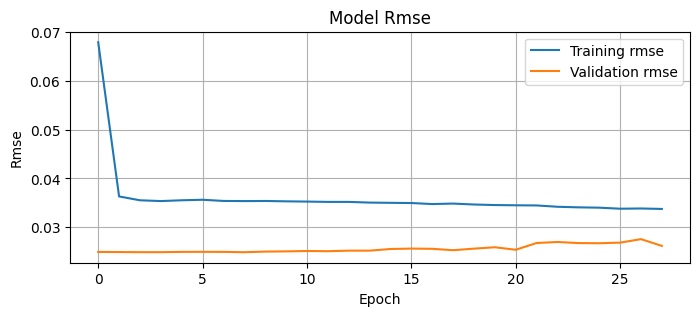


Top 3 Model
Best RMSE: 0.030584 vs. a std of 0.030613
Model parameters: {'filters': 128, 'kernel_size': 4, 'pool_size': 1, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}
n_steps: 30, batch_size: 16


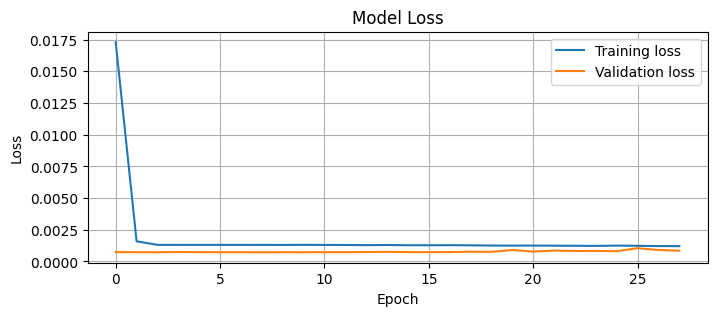

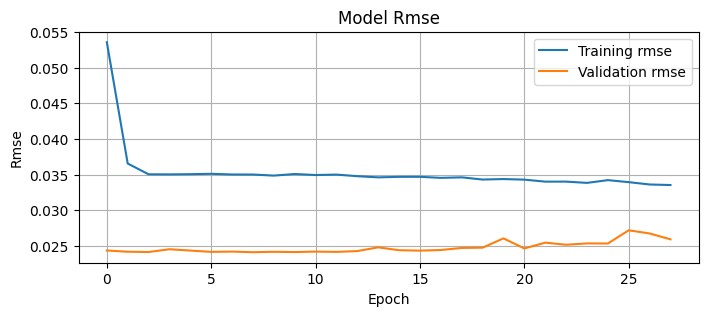

In [ ]:
for i, result in enumerate(top_3_results, 1):
    rmse            = result['rmse']
    model_params    = result['params']
    history         = result['history']
    batch_size      = result['batch_size']
    n_steps         = result['n_steps']
    y_test          = result['y_test']

    print(f"\nTop {i} Model")
    print(f"Best RMSE: {rmse:.6f} vs. a std of {y_test.std():.6f}")
    print(f"Model parameters: {model_params}")
    print(f"n_steps: {n_steps}, batch_size: {batch_size}")

    plot_history(history)